In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) & np.isfinite(stars['[M/H]'])

stars = stars.loc[idx,:].reset_index(drop=True)
       
idx = ~np.isfinite(stars['Dnu'])
stars.loc[idx, 'Dnu'] = stars.loc[idx, 'Dnu_guess']

modes = pd.read_excel(rootpath+'surface/sample/modes.xlsx')

In [3]:
suf = '_micp'
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'surf_corr_at_numax', 'amlt', ]
to_append_cols = ['mass'+suf, 'radius'+suf, 'Dnu'+suf, 'surf_corr'+suf, 'amlt'+suf, ]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)

stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

  0%|          | 0/1276 [00:00<?, ?it/s]

In [4]:
for suffix in ['_micp']: #, '_combined_linear']: #
    gval = 'g'+suffix
    dval = 'density'+suffix
    mval = 'mass'+suffix
    rval = 'radius'+suffix
    e_gval = 'e_g'+suffix
    e_dval = 'e_density'+suffix
    e_mval = 'e_mass'+suffix
    e_rval = 'e_radius'+suffix
    stars[gval] = stars[mval]/stars[rval]**2.
    stars[e_gval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (2*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[gval]
    stars[dval] = stars[mval]/stars[rval]**3.
    stars[e_dval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (3*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[dval]

0

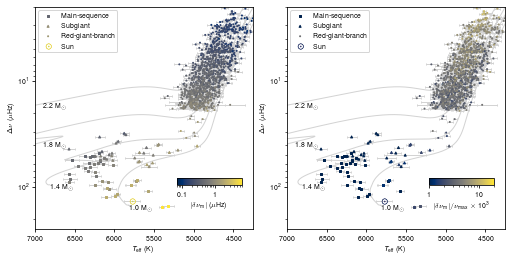

In [5]:
import matplotlib.colors
norm1 = matplotlib.colors.LogNorm(vmin=0.1, vmax=6.) #Normalize(vmin=-5.0, vmax=0.)
norm2 = matplotlib.colors.LogNorm(vmin=1, vmax=16.) #LogNorm

norm1 = matplotlib.colors.LogNorm(vmin=0.07, vmax=7.) #Normalize(vmin=-5.0, vmax=0.)
norm2 = matplotlib.colors.LogNorm(vmin=1, vmax=20.) #LogNorm
cmap = 'cividis'

fig, axes = plt.subplots(figsize=mnras_size(ratio=0.5,column='double'), nrows=1, ncols=2, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

sunstyle = {'marker':'$\\odot$', 's':msize+32, 
            'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha,}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch', 'alpha':alpha,}
msstyle = {'marker':'s', 'cmap': cmap, 's':msize, 'label':'Main-sequence', 'alpha':alpha,}
sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha,}

styles = {'marker':'.', 's':4, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

idx = np.isfinite(stars['mass_micp'])
rg = idx & np.isin(stars['stage'],['rgb','lsg'])
sg = idx & np.isin(stars['stage'],['esg', ])
sun = idx & np.isin(stars['names'],['Sun'])
ms = idx & np.isin(stars['stage'],['ms']) & (~sun)

# axes[0,0].scatter(stars.loc[idx,'Teff'], stars.loc[idx,'Dnu_freq_micp'], c=-stars.loc[idx,'surf_corr_micp'], **styles)

idxes = [ms, sg, rg, sun]
styles = [msstyle, sgstyle, rgstyle, sunstyle]
for i in range(4):
    styles[i]['c'] = -stars.loc[idxes[i], 'surf_corr_micp']
    styles[i]['norm'] = norm1
    if i==3: styles[i]['edgecolor'] = plt.cm.cividis(norm1(5.1))
    axes[0].scatter(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'], rasterized=True, **styles[i])
    axes[0].errorbar(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'],
                    xerr = stars.loc[idxes[i], 'e_Teff'], yerr=stars.loc[idxes[i], 'e_Dnu'], rasterized=True, 
                     **errorstyles)

    styles[i]['c'] = -stars.loc[idxes[i], 'surf_corr_micp']/stars.loc[idxes[i], 'numax']*1e3
    styles[i]['norm'] = norm2
    if i==3: styles[i]['edgecolor'] = plt.cm.cividis(norm2(5.1/3090*1e3))
    axes[1].scatter(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'], rasterized=True,  **styles[i])
    axes[1].errorbar(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'],
                    xerr = stars.loc[idxes[i], 'e_Teff'], yerr=stars.loc[idxes[i], 'e_Dnu'], rasterized=True, 
                     **errorstyles)
    
for iax in range(2):
    axes[iax].axis([7000, 4250, 250., 2.])
    axes[iax].set_yscale('log')
    axes[iax].set_xlabel('$T_{\\rm{eff}}$  (K)')
    axes[iax].set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)')
    axes[iax].legend(fontsize=fontsize)

cax = axes[0].inset_axes([0.65, 0.2, 0.3, 0.03], transform=axes[0].transAxes)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap=cmap), cax=cax, orientation='horizontal')
cb.set_label('$|\\delta\\nu_{\\rm m}|$ ($\\mu$Hz)')
cb.set_ticks([0.1, 1])
cb.set_ticklabels(['0.1', '1'])


cax = axes[1].inset_axes([0.65, 0.2, 0.3, 0.03], transform=axes[1].transAxes)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm2, cmap=cmap), cax=cax, orientation='horizontal')
cb.set_label('$|\\delta\\nu_{\\rm m}|/\\nu_{\\rm max}\\times10^3$')
cb.set_ticks([1, 10])
cb.set_ticklabels(['1', '10'])


# get tracks 
params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
Zsun, Xsun = 0.0134, 0.7381
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
masses = np.array([1.0, 1.4, 1.8, 2.2])
e_mass = 0.01
Yinit, e_Yinit = 0.290, 0.01
amlt, e_amlt = 1.7, 0.02
feh, e_feh = 0., 0.01

indexes = []
for mass in masses:
    metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
    (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
    (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
    (params['feh']-feh)**2.0/e_feh**2.0 
    indexes.append(np.argmin(metric))

indexes = [6167, 6891, 3897, 1093]
for i in indexes:
    data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
    axes[0].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)
    axes[1].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)

    idx = idx & (data['Teff'][:]<6900)
    axes[0].text(data['Teff'][idx][0], data['delta_nu'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)
    axes[1].text(data['Teff'][idx][0], data['delta_nu'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)

filename = 'Fig.4_surf_corr_HRD.pdf'

plt.savefig(filename)
os.system(to_overleaf(filename, 'figures'))

In [13]:
params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(0.0199) #0.0199

In [14]:
params.describe()

,index,star_mass,Xinit,Yinit,Zinit,amlt,fov_shell,fov0_shell,fov_core,fov0_core,feh
count,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8192.000000,8.192000e+03,8.192000e+03,8192.000000,8192.000000,8192.000000
mean,4095.500000,1.500092,0.715733,0.270006,0.014261,2.000131,6.041000e-03,3.020000e-03,0.007436,0.003718,-0.190036
std,2364.971036,0.461908,0.031056,0.028869,0.012791,0.404170,1.023549e-15,4.102871e-16,0.006627,0.003313,0.433039
min,0.000000,0.700240,0.635961,0.220009,0.001564,1.300214,6.041000e-03,3.020000e-03,0.000000,0.000000,-0.939818
25%,2047.750000,1.100167,0.691023,0.245005,0.003930,1.650150,6.041000e-03,3.020000e-03,0.000000,0.000000,-0.564841
50%,4095.500000,1.500095,0.715528,0.270000,0.009250,2.000085,6.041000e-03,3.020000e-03,0.007166,0.003583,-0.189864
75%,6143.250000,1.900022,0.740595,0.294995,0.021573,2.350021,6.041000e-03,3.020000e-03,0.014672,0.007336,0.185114
max,8191.000000,2.299950,0.777915,0.319991,0.052185,2.699957,6.041000e-03,3.020000e-03,0.016193,0.008096,0.560091


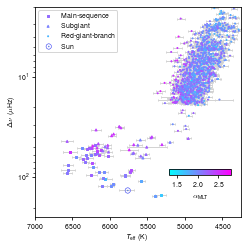

In [ ]:
import matplotlib.colors
norm1 = matplotlib.colors.Normalize(vmin=1.3, vmax=2.8) #Normalize(vmin=-5.0, vmax=0.)

fig, axes = plt.subplots(figsize=mnras_size(ratio=1,column='one'), nrows=1, ncols=1, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

sunstyle = {'marker':'$\\odot$', 's':msize+32, 
            'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha,}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch', 'alpha':alpha,}
msstyle = {'marker':'s', 'cmap': cmap, 's':msize, 'label':'Main-sequence', 'alpha':alpha,}
sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha,}

styles = {'marker':'.', 's':4, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

idx = np.isfinite(stars['mass_micp'])
rg = idx & np.isin(stars['stage'],['rgb','lsg'])
sg = idx & np.isin(stars['stage'],['esg', ])
sun = idx & np.isin(stars['names'],['Sun'])
ms = idx & np.isin(stars['stage'],['ms']) & (~sun)

# axes[0,0].scatter(stars.loc[idx,'Teff'], stars.loc[idx,'Dnu_freq_micp'], c=-stars.loc[idx,'surf_corr_micp'], **styles)

idxes = [ms, sg, rg, sun]
styles = [msstyle, sgstyle, rgstyle, sunstyle]
for i in range(4):
    styles[i]['c'] = stars.loc[idxes[i], 'amlt_micp']
    styles[i]['norm'] = norm1
    if i==3: styles[i]['edgecolor'] = plt.cm.cool(norm1(2.05567))
    axes[0].scatter(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'], rasterized=True, **styles[i])
    axes[0].errorbar(stars.loc[idxes[i], 'Teff'],  stars.loc[idxes[i], 'Dnu'],
                    xerr = stars.loc[idxes[i], 'e_Teff'], yerr=stars.loc[idxes[i], 'e_Dnu'], rasterized=True, 
                     **errorstyles)
    
for iax in range(1):
    axes[iax].axis([7000, 4250, 250., 2.])
    axes[iax].set_yscale('log')
    axes[iax].set_xlabel('$T_{\\rm{eff}}$  (K)')
    axes[iax].set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)')
    axes[iax].legend(fontsize=fontsize)

cax = axes[0].inset_axes([0.65, 0.2, 0.3, 0.03], transform=axes[0].transAxes)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap=cmap), cax=cax, orientation='horizontal')
cb.set_label('$\\alpha_{\\rm MLT}$')
# cb.set_ticks([1.3, 2.8])
# cb.set_ticklabels(['1.', '1'])


# # get tracks 
# params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
# Zsun, Xsun = 0.0134, 0.7381
# params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
# masses = np.array([1.0, 1.4, 1.8, 2.2])
# e_mass = 0.005
# Yinit, e_Yinit = 0.240, 0.01
# amlt, e_amlt = 2.2, 0.02
# feh, e_feh = 0., 0.01
# indexes = []
# for mass in masses:
#     metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
#     (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
#     (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
#     (params['feh']-feh)**2.0/e_feh**2.0 
#     indexes.append(np.argmin(metric))
    
# # print(indexes)
# # params.loc[idx, ['index', 'star_mass', 'Yinit', 'feh', 'amlt']]

# indexes = [7383, 4139, 3257, 981]
# indexes = [7383, 7739, 3257, 981]
# for i in indexes:
#     data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
#     idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
#     axes[0].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)

filename = 'amlt_HRD.pdf'
plt.savefig(filename)

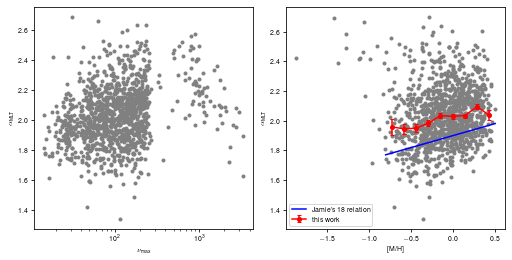

In [117]:
fig, axes = plt.subplots(figsize=mnras_size(ratio=0.5,column='double'), nrows=1, ncols=2, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

idx = (~np.isin(stars['names'], ['ngc6819', 'ngc6791', 'binary'])) & (stars['ifmodelling']==1)
sample = stars.loc[idx,:].reset_index(drop=True)

axes[0].scatter(sample['numax'], sample['amlt_micp'], marker='.', c='gray')
axes[0].set_xscale('log')
axes[0].set_xlabel('$\\nu_{\\rm max}$')
axes[0].set_ylabel('$\\alpha_{\\rm MLT}$')

axes[1].scatter(sample['[M/H]'], sample['amlt_micp'], marker='.', c='gray')
axes[1].set_xlabel('[M/H]')
axes[1].set_ylabel('$\\alpha_{\\rm MLT}$')
xs = np.linspace(-0.8, 0.5, 10)
ys = 0.162*xs+1.9
axes[1].plot(xs, ys, 'b-', label="Jamie's 18 relation")

xcs, medians, stds = se.get_binned_median(sample['[M/H]'].to_numpy(), sample['amlt_micp'].to_numpy(), 
                                          np.linspace(-0.8, 0.5, 10))
estyles = {'linestyle':'-', 'color':'r', 'ecolor':'r', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}
axes[1].errorbar(xcs, medians, yerr=stds, label='this work', **estyles)
# ax.errorbar(x, y, xerr=ex, yerr=ey, rasterized=True, **errorstyles)
# ax.errorbar(xcs, medians, yerr=stds, **estyles)
    

axes[1].legend(fontsize=fontsize)
filename = 'amlt_HRD.pdf'
plt.savefig(filename)

In [102]:
xs

array([-1.])

In [58]:
stars['chi2'] = (stars['mass_micp']-1.0)**2.0/0.02**2.0 + (stars['radius_micp']-8.0)**2.0/0.3**2.0 +(stars['[M/H]']-0.)**2.0/0.05**2.0
stars.sort_values('chi2', ascending=True)[['KIC','Dnu','numax','mass_micp','radius_micp','[M/H]','chi2']].head(10)

# kic = 9932866

,KIC,Dnu,numax,mass_micp,radius_micp,[M/H],chi2
948,9993459,5.237000,48.310000,0.97808,8.413791,0.105798,7.581019
941,9932866,6.724667,67.424574,1.01089,7.117899,-0.011577,8.995661
779,8746834,5.850000,54.690000,1.02017,7.896502,-0.143552,9.378910
686,8113639,5.333923,50.373911,1.03198,8.405088,-0.126952,10.826770
648,7888403,5.187703,47.463847,1.03491,8.550292,-0.110002,11.251587
559,7053383,6.864619,68.736752,1.01196,7.080201,-0.073770,11.934719
775,8738333,5.828396,58.680978,1.06284,7.951979,0.110128,14.749097
1056,10669234,6.586232,64.839689,1.06899,7.371658,0.041691,16.981141
506,6526417,6.954457,69.938020,1.06431,7.133243,0.031618,19.086751
744,8555599,6.330274,62.608197,1.07798,7.638453,0.081956,19.341344


In [53]:
ls ../../hpc/results_sc_combined_linear_ind/8746834/

corner_prob_classical.png       summary_best.txt
corner_prob.png                 summary_prob_classical.txt
corner_prob_seismic.png         summary_prob_seismic.txt
data.h5                         summary_prob.txt
echelle_top10_prob_seismic.png


In [80]:
cat ../../hpc/results_sc_combined_linear_ind/8746834/summary_prob.txt

index,star_age,star_mass,luminosity,radius,Teff,Yinit,Xinit,Zinit,log_g,amlt,FeH,delta_nu_scaling,numax_scaling,profile_number,Dnu_freq_o,surf_corr_at_numax,Dnu_freq
6684.0,8059205404.562836,1.02017,24.98023665982168,7.896166852898304,4592.201024331621,0.23106873,0.7512728,0.00870576,2.651929817015566,1.829742,-0.18958676241385608,6.136403517868037,56.71018984814234,427.0,6.001192158396212,-0.5179784494633737,5.821008196788789
6760.0,10948304184.653128,1.02017,24.980498902117233,7.896502012397087,4592.205677664761,0.23106873,0.76022551,0.00870576,2.651946580869164,1.829742,-0.18958676241385608,6.150094372479953,56.712613614875536,427.0,6.001195283787271,-0.5179153475417272,5.825480794242358
6760.0,10949058179.546698,1.03862,25.670055699754442,7.959964786094692,4592.210330997902,0.23927185,0.76022551,0.00894536,2.6527041452300533,1.829742,-0.1696935019242961,6.150142229170343,56.71503738160874,427.0,6.00119840917833,-0.5178522456200807,5.8255104871718615


This is a very large surface correction... I'm a bit surprised that it doesn't impact the dnu more than it does --- for a solar-metallicity star with log g = 2.4 and dnu of 3.4, the difference in the correction at numax versus at numax + 1*dnu would be 80% of dnu (assuming constant mode inertia within +/- 1dnu)... it would be useful to maybe have a visual of how the surface correction looks like for an example RGB star --- in particular how it impacts the frequency differences of radial modes in the vicinity of numax.

In [84]:
Dnu = 3.4 
logg = 2.4
grav = 10.0**logg/27400
Teff = 5000
3.62*(grav)**1.14 * (Teff/5777)**-10.83
# 5.27*(grav)**0.89 * (Teff/5777)**1.47

0.08223646289329536

In [85]:
-0.08/3.4

-0.023529411764705882

(0.0, 6.954456583, 50.063543417, 91.91315658299999)

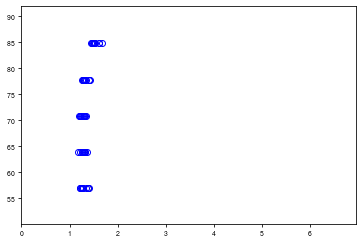

In [67]:
kic = 6526417
f = h5py.File('../../hpc/results_sc_combined_linear_ind/{:0.0f}/data.h5'.format(kic),'r')
f.keys()

fcs_obs = modes.loc[(modes['KIC']==kic)&(modes['l']==0),'fc'].to_numpy()
Dnu = stars.loc[stars['KIC']==kic,'Dnu'].to_numpy()[0]

idxs = np.argsort(f['chi2_seismic'][:])[:10]
plt.errorbar(fcs_obs%Dnu, fcs_obs, marker='o', mec='k', mfc='none', linestyle='none')
for idx in idxs:
    fcs_mod = f['mod_freq'][idx,:]
    plt.errorbar(fcs_mod%Dnu, fcs_obs, marker='o', mec='b', mfc='none', linestyle='none')
plt.axis([0., Dnu, np.min(fcs_obs)-Dnu, np.max(fcs_obs)+Dnu])

In [60]:
f.keys()
# idx
# fcs_obs = modes.loc[(modes['KIC']==9932866)&(modes['l']==0),'fc']
# stars.loc[stars['KIC']==9932866,'Dnu'].to_numpy()[0]

<KeysViewHDF5 ['Dnu_freq', 'Dnu_freq_o', 'FeH', 'Teff', 'Xinit', 'Yinit', 'Zinit', 'amlt', 'chi2', 'chi2_classical', 'chi2_seismic', 'chi2_seismic_l0', 'chi2_seismic_obs_l0', 'chi2_seismic_obs_mod_l0', 'delta_nu_scaling', 'diff_freq', 'eps', 'index', 'log_g', 'luminosity', 'mod_freq', 'numax_scaling', 'profile_number', 'radius', 'star_age', 'star_mass', 'surf_corr_at_numax']>

array([56.88442902, 63.84069544, 70.74391498, 77.77732488, 84.9200929 ])

In [53]:
# ['{:0.1f}'.format(i) for i in cb.get_ticks()]#.
# cb.ax.ticklabel_format(style='plain', axis='x')

In [102]:
idx=stars['KIC']==0
(stars.loc[idx,'surf_corr_micp'])

61   -5.102042
Name: surf_corr_micp, dtype: float64

In [63]:
sample = stars.loc[:,:]
sample['surf_corr1'] = -3.58*(sample['g_micp'])**1.12 * (sample['Teff']/5777.)**-10.5 * (-1.53*sample['[M/H]'] + 1)

idx = np.isin(sample['stage'], ['ms', 'esg'])
sample.loc[idx,'surf_corr2'] = -5.27*(sample.loc[idx,'g_micp'])**0.89 * (sample.loc[idx,'Teff']/5777.)**-1.47 * (0.98*sample.loc[idx,'[M/H]'] + 1)
idx = np.isin(sample['stage'], ['lsg', 'rgb'])
sample.loc[idx,'surf_corr2'] = -3.62*(sample.loc[idx,'g_micp'])**1.14 * (sample.loc[idx,'Teff']/5777.)**-10.83 * (-1.55*sample.loc[idx,'[M/H]'] + 1)

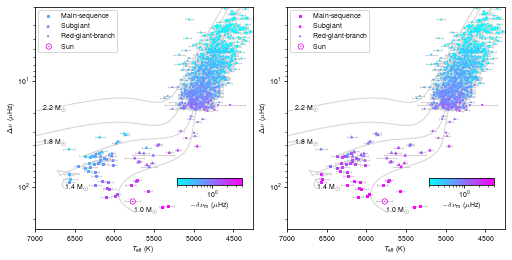

In [67]:
import matplotlib.colors
norm = matplotlib.colors.LogNorm(vmin=0.2, vmax=4.) #Normalize(vmin=-5.0, vmax=0.)
cmap = 'cool'

fig, axes = plt.subplots(figsize=mnras_size(ratio=0.5,column='double'), nrows=1, ncols=2, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

sunstyle = {'marker':'$\\odot$', 's':msize+32, 'edgecolor':plt.cm.cool(norm(3.09149)), 'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha, 'norm':norm}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch', 'alpha':alpha, 'norm':norm}
msstyle = {'marker':'s', 'cmap': cmap, 's':msize, 'label':'Main-sequence', 'alpha':alpha, 'norm':norm}
sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha, 'norm':norm}

styles = {'marker':'.', 's':4, 'norm':norm, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

idx = np.isfinite(sample['mass_micp'])
rg = idx & np.isin(sample['stage'],['rgb','lsg'])
sg = idx & np.isin(sample['stage'],['esg', ])
sun = idx & np.isin(sample['names'],['Sun'])
ms = idx & np.isin(sample['stage'],['ms']) & (~sun)

# axes[0,0].scatter(stars.loc[idx,'Teff'], stars.loc[idx,'Dnu_freq_micp'], c=-stars.loc[idx,'surf_corr_micp'], **styles)

idxes = [ms, sg, rg, sun]
styles = [msstyle, sgstyle, rgstyle, sunstyle]
for i in range(4):
    styles[i]['c'] = -sample.loc[idxes[i], 'surf_corr1']

    axes[0].scatter(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'], **styles[i])
    axes[0].errorbar(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'],
                    xerr = sample.loc[idxes[i], 'e_Teff'], yerr=sample.loc[idxes[i], 'e_Dnu'], 
                     **errorstyles)

    styles[i]['c'] = -sample.loc[idxes[i], 'surf_corr2']

    axes[1].scatter(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'], **styles[i])
    axes[1].errorbar(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'],
                    xerr = sample.loc[idxes[i], 'e_Teff'], yerr=sample.loc[idxes[i], 'e_Dnu'], 
                     **errorstyles)

for iax in range(2):
    axes[iax].axis([7000, 4250, 250., 2.])
    axes[iax].set_yscale('log')
    axes[iax].set_xlabel('$T_{\\rm{eff}}$  (K)')
    axes[iax].set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)')
    axes[iax].legend(fontsize=fontsize)

    cax = axes[iax].inset_axes([0.65, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal').set_label('$-\\delta\\nu_{\\rm m}$ ($\\mu$Hz)')



# get tracks 
params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
Zsun, Xsun = 0.0134, 0.7381
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
masses = np.array([1.0, 1.4, 1.8, 2.2])
e_mass = 0.005
Yinit, e_Yinit = 0.240, 0.01
amlt, e_amlt = 2.2, 0.02
feh, e_feh = 0., 0.01
indexes = []
for mass in masses:
    metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
    (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
    (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
    (params['feh']-feh)**2.0/e_feh**2.0 
    indexes.append(np.argmin(metric))
    
# print(indexes)
# params.loc[idx, ['index', 'star_mass', 'Yinit', 'feh', 'amlt']]

indexes = [7383, 4139, 3257, 981]
indexes = [7383, 7739, 3257, 981]
for i in indexes:
    data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    
    for iax in range(2):
        idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
        axes[iax].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)

        idx = idx & (data['Teff'][:]<6900)
        axes[iax].text(data['Teff'][idx][0], data['delta_nu'][idx][0], '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)


filename = 'surf_corr_HR.pdf'

plt.savefig(filename)
# os.system(to_overleaf(filename, 'figures'))